# M06 Homework

```yaml
course:   DS 5001 
topic:    BOW and TFIDF
author:   JiHo Lee (qxz6hb)
```

### Question 1. What are the top 10 nouns by DFIDF, sorted in descending order? Include plural nouns, but don't include proper nouns.

>| rank |  term_str |      dfidf | max_pos |
|------|----------:|-----------:|---------|
| 1    |   respect | 177.266344 |      NN |
| 2    |  marriage | 177.261968 |      NN |
| 3    |   fortune | 177.261968 |      NN |
| 4    |  question | 177.258990 |      NN |
| 5    |    ladies | 177.258990 |     NNS |
| 6    | behaviour | 177.240001 |      NN |
| 7    |   farther | 177.240001 |      NN |
| 8    | advantage | 177.217644 |      NN |
| 9    |     voice | 177.209470 |      NN |
| 10   |      girl | 177.209470 |      NN |


### Question 2. Grouping your TFIDF results by book, and taking the mean TFIDF of all terms per book, what is Austen's most "significant" book? 

>  PERSUASION by Jane Austen  

>| term_str  | mean_tfidf | max_pos |
|-----------|------------|---------|
| anne      | 0.053947   | NNP     |
| catherine | 0.048607   | NNP     |
| elinor    | 0.047956   | NNP     |
| emma      | 0.043153   | NNP     |
| captain   | 0.040510   | NNP     |
| fanny     | 0.040163   | NNP     |
| marianne  | 0.039716   | NNP     |
| elizabeth | 0.039621   | NNP     |
| vernon    | 0.038256   | NNP     |
| reginald  | 0.036423   | NNP     |



### Question 3. Using the dendograms, which distance measure most clearly distinguishes Austen's two youthful works from her later works? 

> Cityblock <br>


121 (1790) Love and Freindship and other early works <br>
946 (1794) Lady Susan 

### Question 4. Do any of the distance measures produce dendrograms with works sorted in the exact order of their publication years?

> None.

### Question 5. Some literary critics believe that Northanger Abbey is, among Austen's mature works, the one that most resembles her juvenalia,

i.e. her two works written as a young adult.Which distance measure dendrograms appear to corroborate this thesis? In other words, do any of them show that Northanger Abbey is closer to her juvenalia than the her other adult works?

> Based on the dendrograms among these, my opinion is that there is no definitive dendrogram that corroborates this critic. However, Jaccard distance measure seems to be the one that most closely associates "Northanger Abbey" with her juvenalia. <br>
> **Jaccard**


```The code related to questions and answers with explanation is described in each corresponding section below.```

### Set Up
### Import, config, and import the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px

sns.set()

import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home'] 
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'austen-melville'


data_home = data_home.replace('/', '\\')
output_dir = output_dir.replace('/', '\\')

OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)

LIB = pd.read_csv(f"{output_dir}\\{data_prefix}-LIB.csv").set_index('book_id')
TOKEN = pd.read_csv(f'{output_dir}\\{data_prefix}-CORPUS.csv').set_index(OHCO).dropna()
# VOCAB = pd.read_csv(f'{output_dir}\\{data_prefix}-VOCAB.csv').set_index('term_str').dropna()
# POS_GROUP = pd.read_csv(f'{output_dir}/{data_prefix}-POS_GROUP.csv').set_index('pos_group')

The function to generate a BOW

In [2]:
def gen_bag(TOKEN, ohco_level):
    
    bag_tmp = ohco_level
    ans = TOKEN.groupby(bags[bag_tmp]+['term_str']).term_str.count().to_frame('n') 
    
    return ans

The function that returns the TFIDF, DFIDF values for a given BOW

In [3]:
def cal_tfidf(BOW, TF_type):
#     log2(N/DF)
#     N : the number of documents (aka 'bags') in the BOW

    DTCM = BOW.n.unstack(fill_value=0)
    method = TF_type
    print('TF method:', method)

    if method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif method == 'raw':
        TF = DTCM.T
    elif method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T
    
    DF = DTCM.astype('bool').sum() 
    N = DTCM.shape[0]
    
    idf_method = 'standard'   # standard, max, smooth
    if idf_method == 'standard':
        IDF = np.log2(N / DF)
    elif idf_method == 'max':
        IDF = np.log2(DF.max() / DF) 
    elif idf_method == 'smooth':
        IDF = np.log2((1 + N) / (1 + DF)) + 1
    
    TFIDF = TF * IDF
    
#     homework 6 : return dfidf too.
    DFIDF = DF*IDF
    
    return TFIDF, DFIDF
# BOW['tf'] = TF.stack()
# BOW['tfidf'] = TFIDF.stack()

In [4]:
# homework 6
# new VOCAB table for jane austen
AUS_IDX = LIB[LIB.author.str.contains('AUS')].index
TOKEN = TOKEN.loc[AUS_IDX]
VOCAB = TOKEN.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = np.log2(1/VOCAB.p)
VOCAB['max_pos'] = TOKEN.reset_index().value_counts(['term_str','pos']).sort_index().unstack().idxmax(1)
VOCAB

,n,p,i,max_pos
term_str,,,,
the,28274,0.036214,4.787316,DT
to,26029,0.033338,4.906673,TO
and,24060,0.030816,5.020156,CC
of,22927,0.029365,5.089745,IN
a,14301,0.018317,5.770676,DT
...,...,...,...,...
contagion,1,0.000001,19.574505,NN
purposed,1,0.000001,19.574505,VBN
stanwix,1,0.000001,19.574505,NNP


In [5]:
# add to LIB table
# label: use combination of the year and the book title
# scholarly side note: publication year

data = {'book_id': [158, 946, 1212, 141,121,105,1342, 161],
        'year': [1815,1794,1790,1814,1803, 1818, 1813, 1811],
        'title': [
        'Emma',
        'Lady Susan',
        'Love And Freindship And Other Early Works',
        'Mansfield Park',
        'Northanger Abbey',
        'Persuasion',
        'Pride and Prejudice',
        'Sense and Sensibility'
        ]
       }

df = pd.DataFrame(data)
# df = df.sort_values(by='book_id')
df.set_index('book_id', inplace=True)
df = df.sort_index()

LIB2 = LIB[LIB.author.str.contains('AUS')]
LIB = LIB2

LIB = LIB.join(df[['year']])
LIB['label'] = LIB.author.str.split(',').str[0] + ': ' + LIB.title.str[:20] +  ' (' + LIB.year.astype('str') + ')'
LIB

,source_file_path,author,title,chap_regex,book_len,n_chaps,year,label
book_id,,,,,,,,
105,C:\DS5001\DS5001_2024_01_R\..\data\gutenberg\a...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24,1818,AUSTEN: PERSUASION (1818)
121,C:\DS5001\DS5001_2024_01_R\..\data\gutenberg\a...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,1803,AUSTEN: NORTHANGER ABBEY (1803)
141,C:\DS5001\DS5001_2024_01_R\..\data\gutenberg\a...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,1814,AUSTEN: MANSFIELD PARK (1814)
158,C:\DS5001\DS5001_2024_01_R\..\data\gutenberg\a...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,1815,AUSTEN: EMMA (1815)
161,C:\DS5001\DS5001_2024_01_R\..\data\gutenberg\a...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50,1811,AUSTEN: SENSE AND SENSIBILIT (1811)
946,C:\DS5001\DS5001_2024_01_R\..\data\gutenberg\a...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$,23116,41,1794,AUSTEN: LADY SUSAN (1794)
1212,C:\DS5001\DS5001_2024_01_R\..\data\gutenberg\a...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$,33265,24,1790,AUSTEN: LOVE AND FREINDSHIP (1790)
1342,C:\DS5001\DS5001_2024_01_R\..\data\gutenberg\a...,"AUSTEN, JANE",PRIDE AND PREJUDICE,^Chapter\s+\d+$,122126,61,1813,AUSTEN: PRIDE AND PREJUDICE (1813)


In [6]:
# done
# Bring into your notebook the functions you created previously to generate a BOW table and compute TFIDF values. Extend the TFIDF function so that it also returns the DFIDF value for each term in the VOCAB.

# apply these functions to the corpus of Austen's works only
# use chapters as bags and max as the TF count method

aus_chap_bow = gen_bag(TOKEN, 'CHAPS')
TFIDF_aus, DFIDF = cal_tfidf(aus_chap_bow, 'max')
# aus_chap_bow

TF method: max


In [8]:
# reduce the number of features in the returned TFIDF matrix to 
# the 1000 most significant terms
# use DFIDF as your significance measure 
# only use terms whose maximum part-of-speech belongs to
# set: NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS (excluding poper nouns)

# sorted dfidf joined with max_pos
sorted_df = DFIDF.sort_values(ascending=False).to_frame('dfidf').join(VOCAB.max_pos)
pos_set = {'NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}

# terms which belongs to the set in Austen corpous
terms = VOCAB[VOCAB['max_pos'].isin(pos_set)].index

# dfidf which belongs to the set (filtered with max_pos)
filtered_pos = sorted_df[sorted_df['max_pos'].isin(pos_set)]

# top 1000 dfidf
dfidf_1000 = filtered_pos.head(1000)

# top 1000 terms
top_terms = dfidf_1000.index

# reduced TFIDF
reduced = TFIDF_aus[top_terms]

In [9]:
# collaps TFIDF matrix
# it contains mean TFIDF of each term by book
# result: matrix with 
# row: bookd IDs
# colums: significant terms


# A = TFIDF_aus.mean().sort_values(ascending=False).to_frame('mean_tfidf').join(VOCAB.max_pos)
TFIDF_aus

collaps = TFIDF_aus.pivot_table(index=['book_id'], aggfunc=np.mean)

In [11]:
# from the LAB
# second method of the above cell
collaps2 = TFIDF_aus.groupby(OHCO[:1]).mean()

In [12]:
# use collaps TFIDF to compute distance missures
# all pairs of books, 
# refer pdist() in the Lab
# use the appropriate normed vector space for each metric
# create a table of book pairs (PAIRS)
# don't compute k-menas clusters

from scipy.spatial.distance import pdist
from numpy.linalg import norm


L0 = collaps2.astype('bool').astype('int') # Binary (Pseudo L)
L1 = collaps2.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = collaps2.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

# Create dataframe with cartesian product of books by books
PAIRS =  pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()

# # Keep only unique pairs of different books
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

# # Name index cols
PAIRS.index.names = ['doc_a', 'doc_b']

# compute distances
PAIRS['cityblock'] = pdist(collaps2, 'cityblock')
# PAIRS['euclidean'] = pdist(collaps2, 'euclidean')
PAIRS['cosine'] = pdist(collaps2, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')  
PAIRS['euclidean'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

# 1212, 946, 121, 161, 1342,141, 158, 105, 
# PAIRS.loc[105].style.background_gradient(cmap="seismic", axis=0)

In [13]:
# create hierarchical agglomerative cluster diagrams for the distance measures
# using the appropriate linkage type
# use LIB in your dendograms

# Distance Measure and Linkage Method Combos
# | Distance Measure | Norming | Linkage  |
# |------------------|---------|----------|  
# | cityblock        | None    | weighted |
# | cosine           | None    | ward     |
# | euclidean        | L2      | ward     |  
# | jaccard          | L0      | weighted | 
# | jensenshannon    | L1      | weighted |
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.label.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

### <mark> Question 1.</mark>

In [14]:
# homework6
# question 1.
# What are the top 10 nouns by DFIDF, sorted in descending order? Include plural nouns, but don't include proper nouns.

# aus_chap_bow = gen_bag(TOKEN.loc[AUS_IDX], 'CHAPS')
# TFIDF_aus, DFIDF = cal_tfidf(aus_chap_bow, 'max')

pos_noun = {'NN', 'NNS'}

terms = VOCAB[VOCAB['max_pos'].isin(pos_noun)].index
filter_noun = dfidf_1000[dfidf_1000['max_pos'].isin(pos_noun)]
# top 1000 dfidf
filter_noun.head(10)

,dfidf,max_pos
term_str,,
respect,177.266344,NN
marriage,177.261968,NN
fortune,177.261968,NN
question,177.258990,NN
ladies,177.258990,NNS
behaviour,177.240001,NN
farther,177.240001,NN
advantage,177.217644,NN
voice,177.209470,NN


### <mark> Question 2.</mark>
 > Persuasion

In [15]:
# Question 2.
# Grouping your TFIDF results by book, and taking the mean TFIDF of all terms per book, 
# what is Austen's most "significant" book? 
# This value is computed from the TFIDF matrix your function returned.

# from the LAB
# second method of the above cell
collaps2 = TFIDF_aus.groupby(OHCO[:1]).mean()
collaps2

significance = collaps2.mean().sort_values(ascending=False).to_frame('mean_tfidf').join(VOCAB.max_pos)
print(significance.head(10))
print()
print("PERSUASION by Jane Austen")

# TFIDF_paras_max.mean().sort_values(ascending=False)\
#     .head(20).to_frame('mean_tfidf').join(VOCAB.max_pos)

           mean_tfidf max_pos
term_str                     
anne         0.053947     NNP
catherine    0.048607     NNP
elinor       0.047956     NNP
emma         0.043153     NNP
captain      0.040510     NNP
fanny        0.040163     NNP
marianne     0.039716     NNP
elizabeth    0.039621     NNP
vernon       0.038256     NNP
reginald     0.036423     NNP

PERSUASION by Jane Austen


<Figure size 640x480 with 0 Axes>

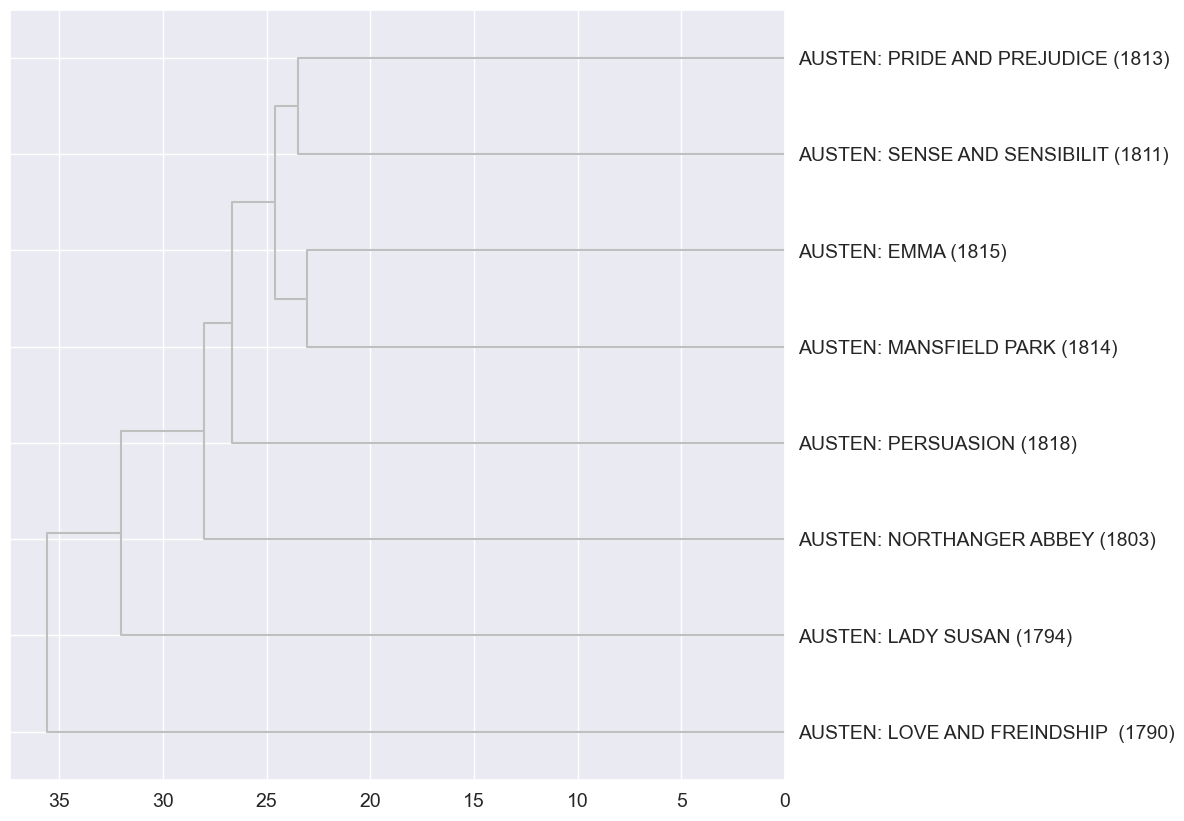

<Figure size 640x480 with 0 Axes>

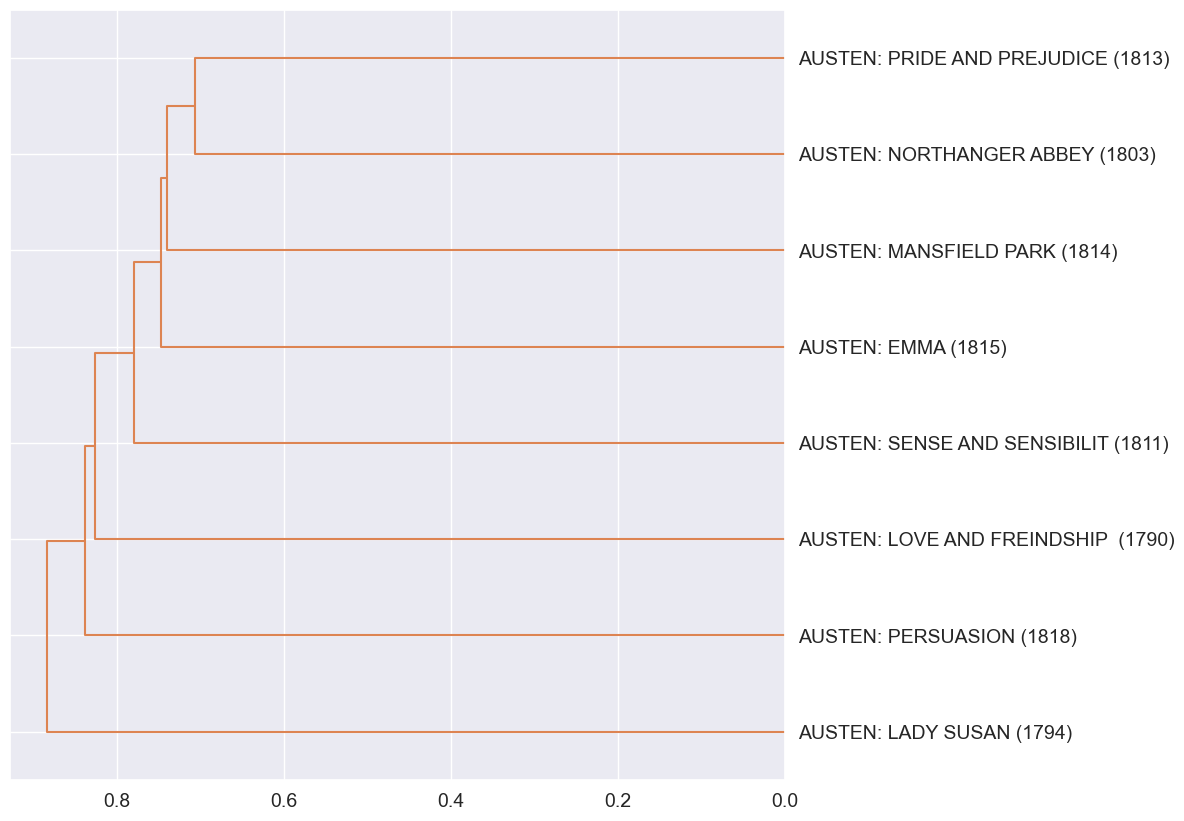

<Figure size 640x480 with 0 Axes>

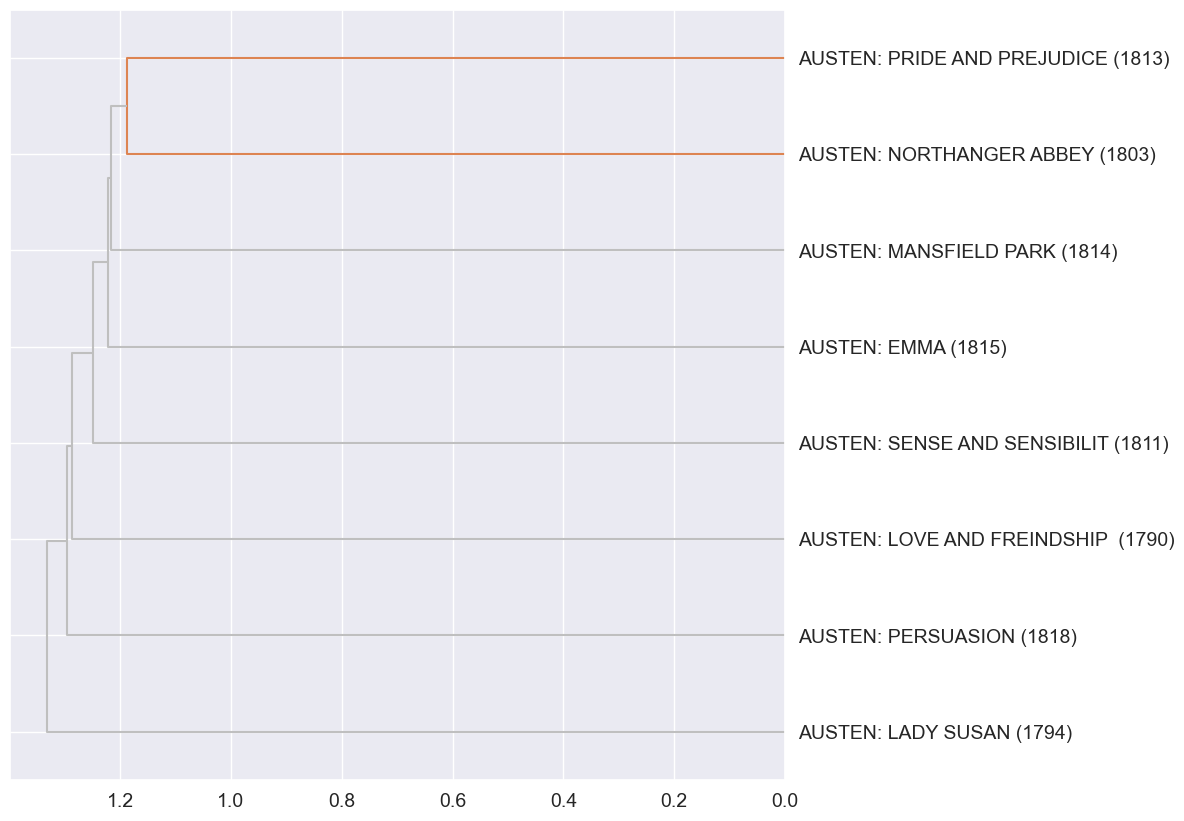

<Figure size 640x480 with 0 Axes>

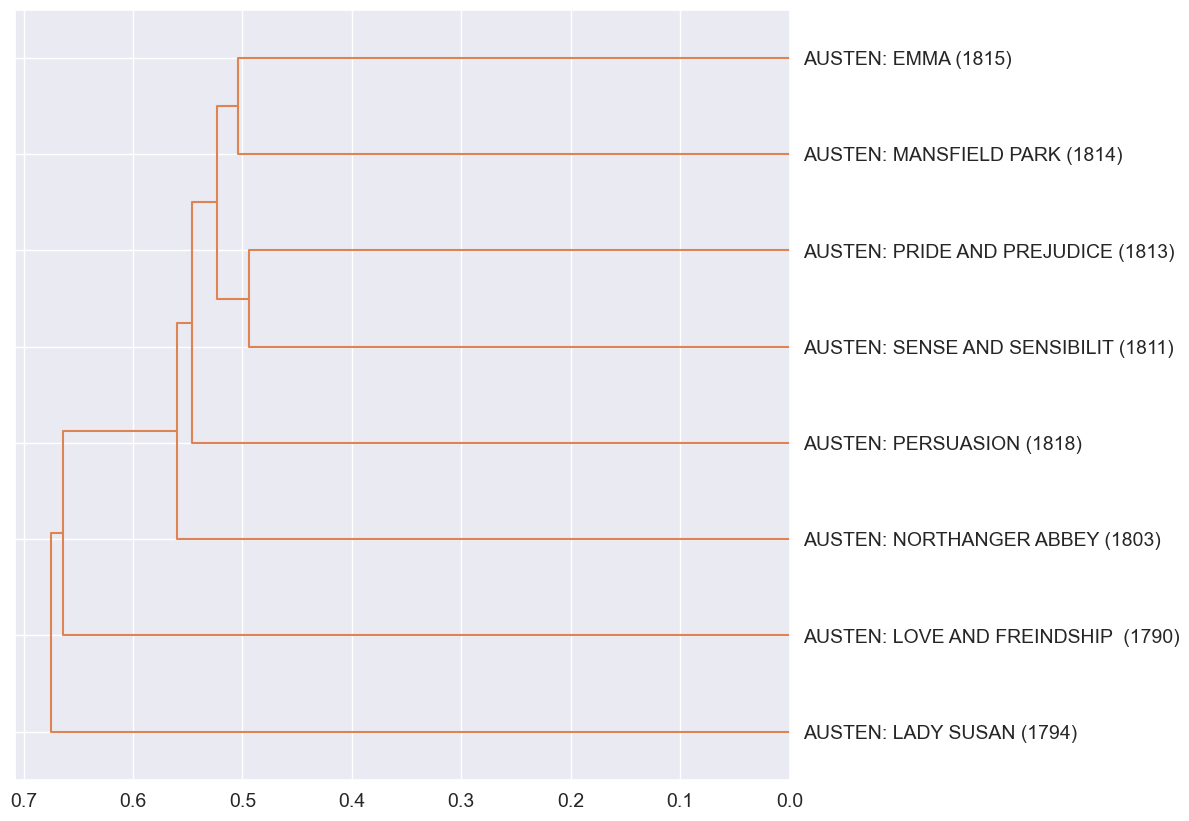

<Figure size 640x480 with 0 Axes>

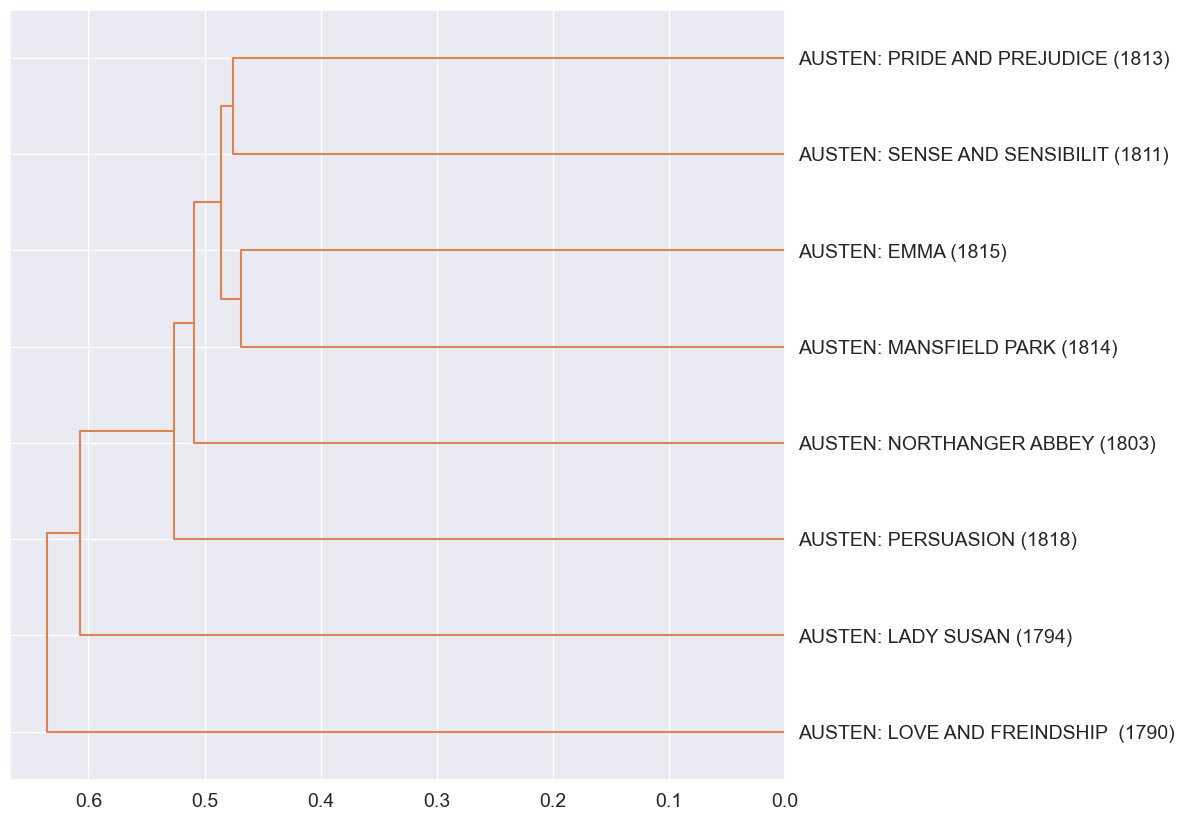

In [16]:
# Distance Measure and Linkage Method Combos
# | Distance Measure | Norming | Linkage  |
# |------------------|---------|----------|  
# | cityblock        | None    | weighted |
# | cosine           | None    | ward     |
# | euclidean        | L2      | ward     |  
# | jaccard          | L0      | weighted | 
# | jensenshannon    | L1      | weighted |

hac(PAIRS.cityblock, linkage_method='weighted', color_thresh=1.2)
hac(PAIRS.cosine, linkage_method='ward', color_thresh=1.2)
hac(PAIRS.euclidean, linkage_method='ward', color_thresh=1.2)
hac(PAIRS.jaccard, linkage_method='weighted', color_thresh=1.2)
hac(PAIRS.js, linkage_method='weighted', color_thresh=1.2)

### <mark>Question 3.</mark>

Using the dendograms, which distance measure most clearly distinguishes Austen's two youthful works from her later works? <br>
that is, which measure show the greatest seperation between the first two work and the rest? <br>
Note that the two youthful works were published before 1800.<br>
 
121 (1790) Love and Freindship and other early works <br>
946 (1794) Lady Susan 

> Cityblock

### <mark>Question 4. </mark>

Do any of the distance measures produce dendrograms with works sorted in the exact order of their publication years?

> None

### <mark> Question 5.</mark>
Some literary critics believe that Northanger Abbey is, among Austen's mature works, the one that most resembles her juvenalia,

i.e. her two works written as a young adult.Which distance measure dendrograms appear to corroborate this thesis? In other words, do any of them show that Northanger Abbey is closer to her juvenalia than the her other adult works?

> Jaccard